
Setup Complete

Loading Data Files
  uniprot1424.fasta: Found
  uniprot356.fasta: Found
  rf452.npz: Found

Original features loaded
  Training: (1424, 452)
  Test: (356, 452)
  Training classes: [712 712] [Non-DBP, DBP]
  Test classes: [178 178] [Non-DBP, DBP]

Loading FASTA Sequences
Sequences loaded
  Training sequences: 1424
  Test sequences: 356

Loading ESM-2 Model
  Model: facebook/esm2_t12_35M_UR50D


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/136M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


ESM-2 model loaded
  Device: cuda
  Embedding dimension: 480

Extracting ESM-2 Embeddings
  Extracting training embeddings (1424 sequences)
    Progress: 0/1424 (0%)
    Progress: 100/1424 (7.0%) - ETA: 0.7 min
    Progress: 200/1424 (14.0%) - ETA: 0.6 min
    Progress: 300/1424 (21.1%) - ETA: 0.6 min
    Progress: 400/1424 (28.1%) - ETA: 0.5 min
    Progress: 500/1424 (35.1%) - ETA: 0.5 min
    Progress: 600/1424 (42.1%) - ETA: 0.4 min
    Progress: 700/1424 (49.2%) - ETA: 0.3 min
    Progress: 800/1424 (56.2%) - ETA: 0.3 min
    Progress: 900/1424 (63.2%) - ETA: 0.2 min
    Progress: 1000/1424 (70.2%) - ETA: 0.2 min
    Progress: 1100/1424 (77.2%) - ETA: 0.1 min
    Progress: 1200/1424 (84.3%) - ETA: 0.1 min
    Progress: 1300/1424 (91.3%) - ETA: 0.0 min
    Progress: 1400/1424 (98.3%) - ETA: 0.0 min
    Completed in 0.6 minutes
  Extracting test embeddings (356 sequences)
    Progress: 0/356 (0%)
    Progress: 100/356 (28.1%) - ETA: 0.1 min
    Progress: 200/356 (56.2%) - ETA: 0.1 m

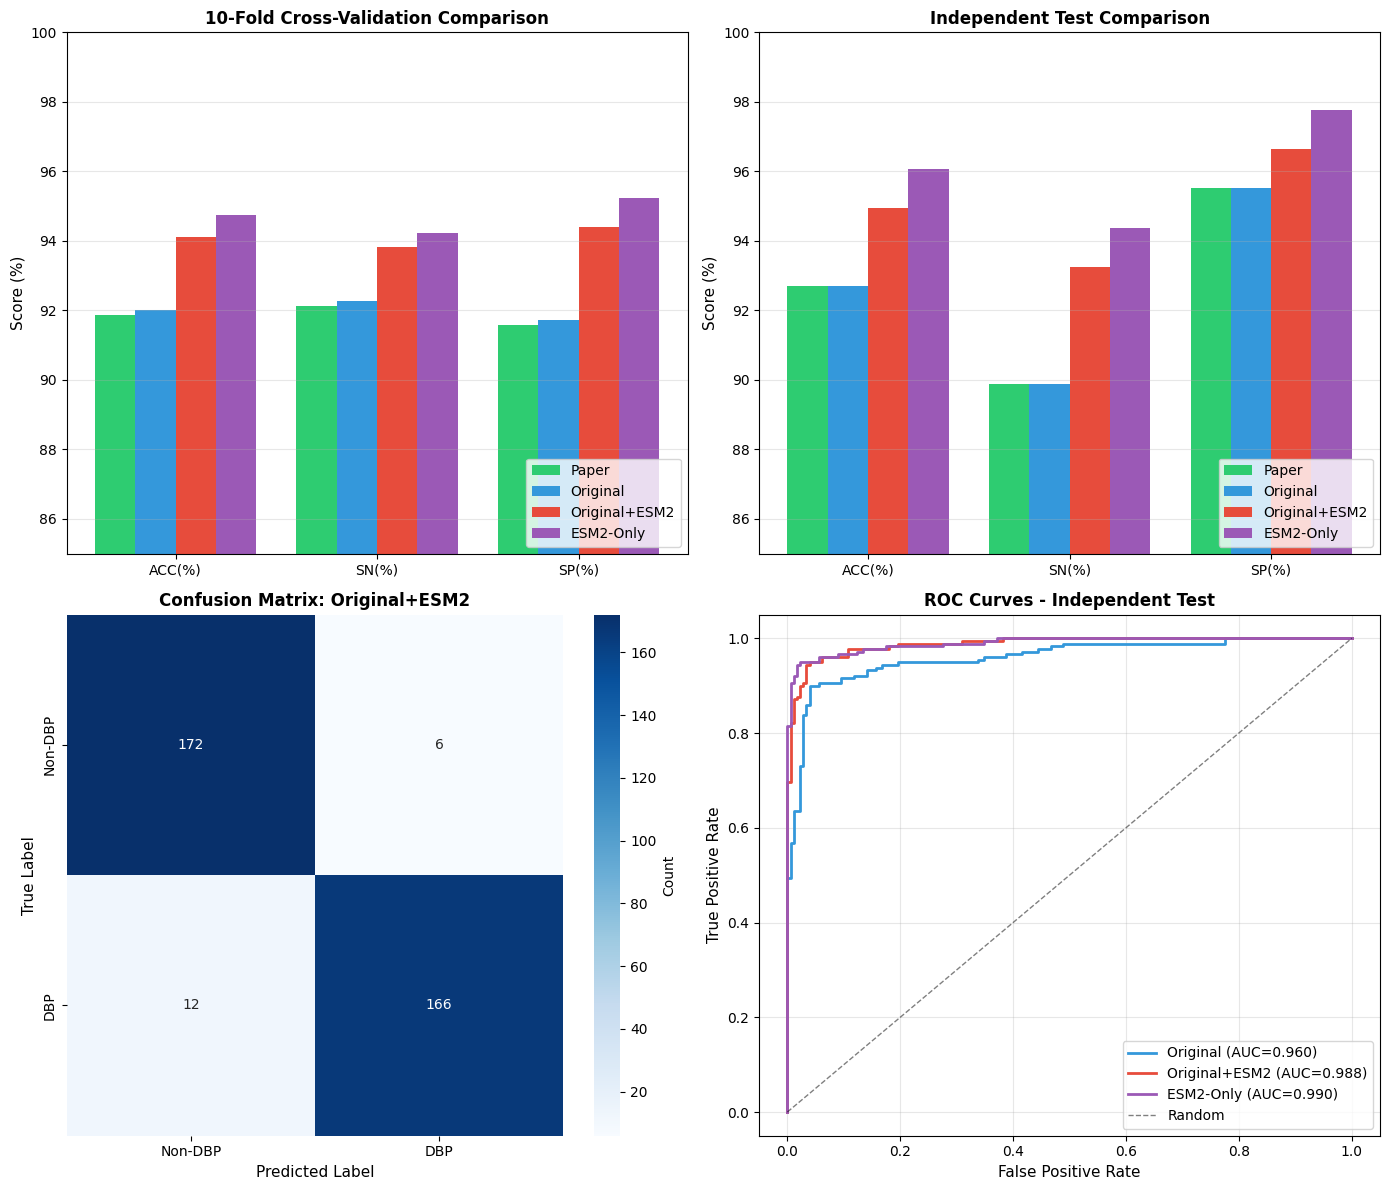

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
================================================================================
ESM-2 ENHANCED DNA-BINDING PROTEIN PREDICTOR
================================================================================

This script enhances StackDPP with ESM-2 protein language model embeddings
using the exact validation methods from the original paper:

1. 10-Fold Cross-Validation
2. Independent Test Set Validation

Date: December 2024

Required Files:
- uniprot1424.fasta (training sequences)
- uniprot356.fasta (test sequences)
- Features/rf452.npz (original StackDPP features)

================================================================================
"""

# ============================================================================
# INSTALL PACKAGES
# ============================================================================

import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

packages = ["transformers", "torch", "sentencepiece", "biopython","seaborn"]

for pkg in packages:
    install(pkg)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# BioPython
from Bio import SeqIO

# PyTorch and Transformers
import torch
from transformers import AutoTokenizer, EsmModel

# Scikit-learn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import (AdaBoostClassifier, StackingClassifier,
                              VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             matthews_corrcoef, roc_auc_score,
                             average_precision_score, confusion_matrix,
                             roc_curve, make_scorer)
from sklearn.model_selection import (StratifiedKFold, cross_validate)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone

print("Setup Complete")



def specificity_score(y_true, y_pred):
    """Calculate specificity (matches original StackDPP implementation)"""
    return (2 * accuracy_score(y_true, y_pred)) - recall_score(y_true, y_pred)


def get_metrics(y_true, y_pred, y_proba=None):
    """Calculate all performance metrics"""
    metrics = {
        'ACC(%)': accuracy_score(y_true, y_pred) * 100,
        'SN(%)': recall_score(y_true, y_pred) * 100,
        'SP(%)': specificity_score(y_true, y_pred) * 100,
        'PREC(%)': precision_score(y_true, y_pred, zero_division=0) * 100,
        'MCC': matthews_corrcoef(y_true, y_pred),
    }

    if y_proba is not None:
        try:
            proba = y_proba[:, 1] if len(y_proba.shape) > 1 else y_proba
            metrics['AUROC'] = roc_auc_score(y_true, proba)
            metrics['AUPR'] = average_precision_score(y_true, proba)
        except Exception as e:
            print(f"  Warning: Could not compute AUROC/AUPR: {e}")

    return metrics


def print_metrics(metrics, title="Results"):
    """Print metrics in formatted table"""
    print(f"\n{'─'*70}")
    print(f"  {title}")
    print(f"{'─'*70}")
    for key, value in metrics.items():
        if 'MCC' in key or 'AUROC' in key or 'AUPR' in key:
            print(f"  {key:<12}: {value:.4f}")
        else:
            print(f"  {key:<12}: {value:.2f}%")
    print(f"{'─'*70}")


def cross_validation_10fold(X, y, model, random_state=0):
    """10-fold cross-validation (matches original StackDPP)"""
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    scoring = {
        "accuracy": make_scorer(accuracy_score),
        "mcc": make_scorer(matthews_corrcoef),
        "precision": make_scorer(precision_score, zero_division=0),
        "specificity": make_scorer(specificity_score, greater_is_better=True),
        "sensitivity": make_scorer(recall_score),
    }

    scores = cross_validate(model, X, y, cv=skf, scoring=scoring,
                           return_train_score=True, return_estimator=True)

    # Calculate AUROC and AUPR manually with probability predictions
    auroc_scores = []
    aupr_scores = []

    for train_idx, test_idx in skf.split(X, y):
        X_train_fold, X_test_fold = X[train_idx], X[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]

        model_clone = clone(model)
        model_clone.fit(X_train_fold, y_train_fold)

        try:
            y_proba = model_clone.predict_proba(X_test_fold)[:, 1]
            auroc_scores.append(roc_auc_score(y_test_fold, y_proba))
            aupr_scores.append(average_precision_score(y_test_fold, y_proba))
        except:
            pass

    return {
        'ACC(%)': np.mean(scores["test_accuracy"]) * 100,
        'SN(%)': np.mean(scores["test_sensitivity"]) * 100,
        'SP(%)': np.mean(scores["test_specificity"]) * 100,
        'PREC(%)': np.mean(scores["test_precision"]) * 100,
        'MCC': np.mean(scores["test_mcc"]),
        'AUROC': np.mean(auroc_scores) if auroc_scores else np.nan,
        'AUPR': np.mean(aupr_scores) if aupr_scores else np.nan,
    }


def independent_test(X_train, y_train, X_test, y_test, model):
    """Independent test set validation"""
    model_clone = clone(model)
    model_clone.fit(X_train, y_train)

    y_pred = model_clone.predict(X_test)

    try:
        y_proba = model_clone.predict_proba(X_test)
    except:
        y_proba = None

    return get_metrics(y_test, y_pred, y_proba), y_pred, y_proba

# LOAD DATA FILES

print("Loading Data Files")

# Get the script directory and workspace root
script_dir = os.path.dirname(os.path.abspath(__file__))
workspace_root = os.path.dirname(script_dir)

TRAIN_FASTA = os.path.join(workspace_root, 'Dataset', 'uniprot1424.fasta')
TEST_FASTA = os.path.join(workspace_root, 'Dataset', 'uniprot356.fasta')
FEATURES_FILE = os.path.join(workspace_root, 'Features', 'rf452.npz')

files_status = {
    'uniprot1424.fasta': os.path.exists(TRAIN_FASTA),
    'uniprot356.fasta': os.path.exists(TEST_FASTA),
    'rf452.npz': os.path.exists(FEATURES_FILE)
}

for fname, exists in files_status.items():
    status = "Found" if exists else "Missing"
    print(f"  {fname}: {status}")

if not all(files_status.values()):
    print("\nERROR: Missing required files")
    raise FileNotFoundError("Please upload all required files")

# Load original 452 features
data = np.load(FEATURES_FILE)
X_original = data['X']
y_train = data['y']
X_test_original = data['test_X']
y_test = data['test_y']

print(f"\nOriginal features loaded")
print(f"  Training: {X_original.shape}")
print(f"  Test: {X_test_original.shape}")
print(f"  Training classes: {np.bincount(y_train)} [Non-DBP, DBP]")
print(f"  Test classes: {np.bincount(y_test)} [Non-DBP, DBP]")

# LOAD FASTA SEQUENCES

print("Loading FASTA Sequences")

def load_fasta_sequences(fasta_file):
    """Load protein sequences from FASTA file"""
    sequences = []
    ids = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        ids.append(record.id)
        sequences.append(str(record.seq))
    return sequences, ids

train_sequences, train_ids = load_fasta_sequences(TRAIN_FASTA)
test_sequences, test_ids = load_fasta_sequences(TEST_FASTA)

print(f"Sequences loaded")
print(f"  Training sequences: {len(train_sequences)}")
print(f"  Test sequences: {len(test_sequences)}")

if len(train_sequences) != X_original.shape[0]:
    print(f"\nWarning: Sequence count mismatch with features")

# LOAD ESM-2 MODEL

print("Loading ESM-2 Model")

MODEL_NAME = "facebook/esm2_t12_35M_UR50D"
print(f"  Model: {MODEL_NAME}")

import warnings
warnings.filterwarnings('ignore')

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
esm_model = EsmModel.from_pretrained(MODEL_NAME)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
esm_model = esm_model.to(device)
esm_model.eval()

EMBEDDING_DIM = esm_model.config.hidden_size

print(f"ESM-2 model loaded")
print(f"  Device: {device}")
print(f"  Embedding dimension: {EMBEDDING_DIM}")

# EXTRACT ESM-2 EMBEDDINGS

print("Extracting ESM-2 Embeddings")

def get_esm2_embedding(sequence, tokenizer, model, device, max_length=1022):
    """Extract ESM-2 embedding for a single protein sequence"""
    if len(sequence) > max_length:
        sequence = sequence[:max_length]

    inputs = tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state
    embedding = embeddings[0, 1:-1, :].mean(dim=0)

    return embedding.cpu().numpy()


def extract_all_embeddings(sequences, tokenizer, model, device, batch_name=""):
    """Extract embeddings for all sequences with progress tracking"""
    embeddings = []
    n_seqs = len(sequences)

    print(f"  Extracting {batch_name} embeddings ({n_seqs} sequences)")
    start_time = datetime.now()

    for i, seq in enumerate(sequences):
        if i % 100 == 0:
            elapsed = (datetime.now() - start_time).total_seconds()
            if i > 0:
                eta = elapsed / i * (n_seqs - i)
                print(f"    Progress: {i}/{n_seqs} ({100*i/n_seqs:.1f}%) - ETA: {eta/60:.1f} min")
            else:
                print(f"    Progress: {i}/{n_seqs} (0%)")

        emb = get_esm2_embedding(seq, tokenizer, model, device)
        embeddings.append(emb)

    elapsed = (datetime.now() - start_time).total_seconds()
    print(f"    Completed in {elapsed/60:.1f} minutes")

    return np.array(embeddings)


EMBEDDINGS_FILE = os.path.join(workspace_root, 'esm2_embeddings.npz')

if os.path.exists(EMBEDDINGS_FILE):
    print("  Loading pre-computed embeddings...")
    emb_data = np.load(EMBEDDINGS_FILE)
    train_esm_embeddings = emb_data['train']
    test_esm_embeddings = emb_data['test']
    print(f"  Loaded from cache")
else:
    train_esm_embeddings = extract_all_embeddings(
        train_sequences, tokenizer, esm_model, device, "training"
    )
    test_esm_embeddings = extract_all_embeddings(
        test_sequences, tokenizer, esm_model, device, "test"
    )
    np.savez(EMBEDDINGS_FILE, train=train_esm_embeddings, test=test_esm_embeddings)
    print(f"  Embeddings saved to {EMBEDDINGS_FILE}")

print(f"\nESM-2 embeddings ready")
print(f"  Training: {train_esm_embeddings.shape}")
print(f"  Test: {test_esm_embeddings.shape}")

# PREPARE FEATURE SETS

print("Preparing Feature Sets")

# Feature Set 1: Original 452 features
scaler_original = StandardScaler()
X_train_original = scaler_original.fit_transform(X_original)
X_test_original_scaled = scaler_original.transform(X_test_original)

print("Feature Set 1: Original (452 features)")
print(f"  Training: {X_train_original.shape}")
print(f"  Test: {X_test_original_scaled.shape}")

# Feature Set 2: Original + ESM-2
X_train_combined = np.concatenate([X_original, train_esm_embeddings], axis=1)
X_test_combined = np.concatenate([X_test_original, test_esm_embeddings], axis=1)

scaler_combined = StandardScaler()
X_train_combined = scaler_combined.fit_transform(X_train_combined)
X_test_combined = scaler_combined.transform(X_test_combined)

print("\nFeature Set 2: Original + ESM-2")
print(f"  Original features: {X_original.shape[1]}")
print(f"  ESM-2 features: {train_esm_embeddings.shape[1]}")
print(f"  Combined features: {X_train_combined.shape[1]}")
print(f"  Training: {X_train_combined.shape}")
print(f"  Test: {X_test_combined.shape}")

# Feature Set 3: ESM-2 only
scaler_esm = StandardScaler()
X_train_esm_only = scaler_esm.fit_transform(train_esm_embeddings)
X_test_esm_only = scaler_esm.transform(test_esm_embeddings)

print("\nFeature Set 3: ESM-2 only")
print(f"  Training: {X_train_esm_only.shape}")
print(f"  Test: {X_test_esm_only.shape}")

# DEFINE MODEL

print("Defining StackDPP Model")

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

def create_stackdpp_model():
    """
    Create StackDPP model as described in the original paper.

    Architecture:
    - Level 0: VotingClassifier(DT, AdaBoost, LDA) + SVM(RBF, tuned)
    - Level 1: Logistic Regression
    """
    return StackingClassifier(
        estimators=[
            ('VC', VotingClassifier(
                estimators=[
                    ('DT', DecisionTreeClassifier(random_state=0)),
                    ('ABC', AdaBoostClassifier(random_state=0)),
                    ('LDA', LinearDiscriminantAnalysis()),
                ],
                voting='soft',
                n_jobs=-1
            )),
            ('SVM', SVC(
                kernel='rbf',
                C=5.44,
                gamma=0.00237,
                random_state=0,
                probability=True
            ))
        ],
        final_estimator=LogisticRegression(solver='liblinear', random_state=0, max_iter=10000),
        stack_method='predict_proba',
        cv=skf,
        n_jobs=-1
    )

print("Model architecture defined")

# RUN VALIDATIONS

print("Running Validations")

results = {}

paper_results = {
    '10-Fold CV': {'ACC(%)': 91.86, 'SN(%)': 92.13, 'SP(%)': 91.57, 'MCC': 0.84},
    'Independent': {'ACC(%)': 92.70, 'SN(%)': 89.89, 'SP(%)': 95.51, 'MCC': 0.86,
                   'AUROC': 0.93, 'AUPR': 0.97}
}

# TEST 1: Original Features (452) - Baseline Replication
print("\n" + "─"*70)
print("TEST 1: ORIGINAL STACKDPP (452 features)")
print("─"*70)

model_original = create_stackdpp_model()

print("  Running 10-Fold Cross-Validation...")
cv_original = cross_validation_10fold(X_train_original, y_train, model_original)
print_metrics(cv_original, "Original - 10-Fold CV")

print("  Running Independent Test...")
ind_original, pred_orig, proba_orig = independent_test(
    X_train_original, y_train, X_test_original_scaled, y_test, model_original
)
print_metrics(ind_original, "Original - Independent Test")

results['Original (452)'] = {
    '10-Fold CV': cv_original,
    'Independent': ind_original
}

# TEST 2: Original + ESM-2 Features

print("\n" + "─"*70)
print("TEST 2: ORIGINAL + ESM-2 FEATURES")
print("─"*70)

model_combined = create_stackdpp_model()

print("  Running 10-Fold Cross-Validation...")
cv_combined = cross_validation_10fold(X_train_combined, y_train, model_combined)
print_metrics(cv_combined, "Original+ESM2 - 10-Fold CV")

print("  Running Independent Test...")
ind_combined, pred_comb, proba_comb = independent_test(
    X_train_combined, y_train, X_test_combined, y_test, model_combined
)
print_metrics(ind_combined, "Original+ESM2 - Independent Test")

results['Original+ESM2'] = {
    '10-Fold CV': cv_combined,
    'Independent': ind_combined
}


# TEST 3: ESM-2 Features Only
print("\n" + "─"*70)
print("TEST 3: ESM-2 FEATURES ONLY")
print("─"*70)

model_esm = create_stackdpp_model()

print("  Running 10-Fold Cross-Validation...")
cv_esm = cross_validation_10fold(X_train_esm_only, y_train, model_esm)
print_metrics(cv_esm, "ESM2-Only - 10-Fold CV")

print("  Running Independent Test...")
ind_esm, pred_esm, proba_esm = independent_test(
    X_train_esm_only, y_train, X_test_esm_only, y_test, model_esm
)
print_metrics(ind_esm, "ESM2-Only - Independent Test")

results['ESM2-Only'] = {
    '10-Fold CV': cv_esm,
    'Independent': ind_esm
}

# COMPREHENSIVE COMPARISON

print("Comprehensive Comparison")

print("\n" + "─"*90)
print("10-FOLD CROSS-VALIDATION COMPARISON")
print("─"*90)
print(f"{'Feature Set':<20} {'ACC(%)':<12} {'SN(%)':<12} {'SP(%)':<12} {'MCC':<12}")
print("─"*90)
print(f"{'Paper (StackDPP)':<20} {paper_results['10-Fold CV']['ACC(%)']:<12.2f} "
      f"{paper_results['10-Fold CV']['SN(%)']:<12.2f} "
      f"{paper_results['10-Fold CV']['SP(%)']:<12.2f} "
      f"{paper_results['10-Fold CV']['MCC']:<12.4f}")
print(f"{'Original (452)':<20} {cv_original['ACC(%)']:<12.2f} "
      f"{cv_original['SN(%)']:<12.2f} "
      f"{cv_original['SP(%)']:<12.2f} "
      f"{cv_original['MCC']:<12.4f}")
print(f"{'Original+ESM2':<20} {cv_combined['ACC(%)']:<12.2f} "
      f"{cv_combined['SN(%)']:<12.2f} "
      f"{cv_combined['SP(%)']:<12.2f} "
      f"{cv_combined['MCC']:<12.4f}")
print(f"{'ESM2-Only':<20} {cv_esm['ACC(%)']:<12.2f} "
      f"{cv_esm['SN(%)']:<12.2f} "
      f"{cv_esm['SP(%)']:<12.2f} "
      f"{cv_esm['MCC']:<12.4f}")
print("─"*90)

print("\n" + "─"*90)
print("INDEPENDENT TEST COMPARISON")
print("─"*90)
print(f"{'Feature Set':<20} {'ACC(%)':<10} {'SN(%)':<10} {'SP(%)':<10} "
      f"{'MCC':<10} {'AUROC':<10} {'AUPR':<10}")
print("─"*90)
print(f"{'Paper (StackDPP)':<20} {paper_results['Independent']['ACC(%)']:<10.2f} "
      f"{paper_results['Independent']['SN(%)']:<10.2f} "
      f"{paper_results['Independent']['SP(%)']:<10.2f} "
      f"{paper_results['Independent']['MCC']:<10.4f} "
      f"{paper_results['Independent']['AUROC']:<10.4f} "
      f"{paper_results['Independent']['AUPR']:<10.4f}")
print(f"{'Original (452)':<20} {ind_original['ACC(%)']:<10.2f} "
      f"{ind_original['SN(%)']:<10.2f} "
      f"{ind_original['SP(%)']:<10.2f} "
      f"{ind_original['MCC']:<10.4f} "
      f"{ind_original.get('AUROC', 0):<10.4f} "
      f"{ind_original.get('AUPR', 0):<10.4f}")
print(f"{'Original+ESM2':<20} {ind_combined['ACC(%)']:<10.2f} "
      f"{ind_combined['SN(%)']:<10.2f} "
      f"{ind_combined['SP(%)']:<10.2f} "
      f"{ind_combined['MCC']:<10.4f} "
      f"{ind_combined.get('AUROC', 0):<10.4f} "
      f"{ind_combined.get('AUPR', 0):<10.4f}")
print(f"{'ESM2-Only':<20} {ind_esm['ACC(%)']:<10.2f} "
      f"{ind_esm['SN(%)']:<10.2f} "
      f"{ind_esm['SP(%)']:<10.2f} "
      f"{ind_esm['MCC']:<10.4f} "
      f"{ind_esm.get('AUROC', 0):<10.4f} "
      f"{ind_esm.get('AUPR', 0):<10.4f}")
print("─"*90)

print("\n" + "─"*90)
print("IMPROVEMENT ANALYSIS (Original+ESM2 vs Original)")
print("─"*90)

improvements_combined = {
    'ACC(%)': ind_combined['ACC(%)'] - ind_original['ACC(%)'],
    'SN(%)': ind_combined['SN(%)'] - ind_original['SN(%)'],
    'SP(%)': ind_combined['SP(%)'] - ind_original['SP(%)'],
    'MCC': ind_combined['MCC'] - ind_original['MCC'],
}

for metric, improvement in improvements_combined.items():
    direction = "improved" if improvement > 0 else "declined" if improvement < 0 else "unchanged"
    if metric == 'MCC':
        print(f"  {metric}: {improvement:+.4f} ({direction})")
    else:
        print(f"  {metric}: {improvement:+.2f}% ({direction})")

print("\n" + "─"*90)
print("IMPROVEMENT ANALYSIS (ESM2-Only vs Original)")
print("─"*90)

improvements_esm = {
    'ACC(%)': ind_esm['ACC(%)'] - ind_original['ACC(%)'],
    'SN(%)': ind_esm['SN(%)'] - ind_original['SN(%)'],
    'SP(%)': ind_esm['SP(%)'] - ind_original['SP(%)'],
    'MCC': ind_esm['MCC'] - ind_original['MCC'],
}

for metric, improvement in improvements_esm.items():
    direction = "improved" if improvement > 0 else "declined" if improvement < 0 else "unchanged"
    if metric == 'MCC':
        print(f"  {metric}: {improvement:+.4f} ({direction})")
    else:
        print(f"  {metric}: {improvement:+.2f}% ({direction})")

# VISUALIZATIONS

print("Generating Visualizations")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. 10-Fold CV Comparison
ax1 = axes[0, 0]
metrics_to_plot = ['ACC(%)', 'SN(%)', 'SP(%)']
x = np.arange(len(metrics_to_plot))
width = 0.2

bars1 = ax1.bar(x - 1.5*width, [paper_results['10-Fold CV'][m] for m in metrics_to_plot],
                width, label='Paper', color='#2ecc71')
bars2 = ax1.bar(x - 0.5*width, [cv_original[m] for m in metrics_to_plot],
                width, label='Original', color='#3498db')
bars3 = ax1.bar(x + 0.5*width, [cv_combined[m] for m in metrics_to_plot],
                width, label='Original+ESM2', color='#e74c3c')
bars4 = ax1.bar(x + 1.5*width, [cv_esm[m] for m in metrics_to_plot],
                width, label='ESM2-Only', color='#9b59b6')

ax1.set_ylabel('Score (%)', fontsize=11)
ax1.set_title('10-Fold Cross-Validation Comparison', fontweight='bold', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_to_plot)
ax1.legend(loc='lower right')
ax1.set_ylim([85, 100])
ax1.grid(axis='y', alpha=0.3)

# 2. Independent Test Comparison
ax2 = axes[0, 1]
bars5 = ax2.bar(x - 1.5*width, [paper_results['Independent'][m] for m in metrics_to_plot],
                width, label='Paper', color='#2ecc71')
bars6 = ax2.bar(x - 0.5*width, [ind_original[m] for m in metrics_to_plot],
                width, label='Original', color='#3498db')
bars7 = ax2.bar(x + 0.5*width, [ind_combined[m] for m in metrics_to_plot],
                width, label='Original+ESM2', color='#e74c3c')
bars8 = ax2.bar(x + 1.5*width, [ind_esm[m] for m in metrics_to_plot],
                width, label='ESM2-Only', color='#9b59b6')

ax2.set_ylabel('Score (%)', fontsize=11)
ax2.set_title('Independent Test Comparison', fontweight='bold', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_to_plot)
ax2.legend(loc='lower right')
ax2.set_ylim([85, 100])
ax2.grid(axis='y', alpha=0.3)

# 3. Confusion Matrix - Original+ESM2
ax3 = axes[1, 0]
cm = confusion_matrix(y_test, pred_comb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Non-DBP', 'DBP'],
            yticklabels=['Non-DBP', 'DBP'],
            cbar_kws={'label': 'Count'})
ax3.set_title('Confusion Matrix: Original+ESM2', fontweight='bold', fontsize=12)
ax3.set_ylabel('True Label', fontsize=11)
ax3.set_xlabel('Predicted Label', fontsize=11)

# 4. ROC Curves
ax4 = axes[1, 1]
if proba_orig is not None:
    fpr_orig, tpr_orig, _ = roc_curve(y_test, proba_orig[:, 1])
    ax4.plot(fpr_orig, tpr_orig,
             label=f'Original (AUC={ind_original.get("AUROC", 0):.3f})',
             color='#3498db', lw=2)

if proba_comb is not None:
    fpr_comb, tpr_comb, _ = roc_curve(y_test, proba_comb[:, 1])
    ax4.plot(fpr_comb, tpr_comb,
             label=f'Original+ESM2 (AUC={ind_combined.get("AUROC", 0):.3f})',
             color='#e74c3c', lw=2)

if proba_esm is not None:
    fpr_esm, tpr_esm, _ = roc_curve(y_test, proba_esm[:, 1])
    ax4.plot(fpr_esm, tpr_esm,
             label=f'ESM2-Only (AUC={ind_esm.get("AUROC", 0):.3f})',
             color='#9b59b6', lw=2)

ax4.plot([0, 1], [0, 1], 'k--', lw=1, label='Random', alpha=0.5)
ax4.set_xlabel('False Positive Rate', fontsize=11)
ax4.set_ylabel('True Positive Rate', fontsize=11)
ax4.set_title('ROC Curves - Independent Test', fontweight='bold', fontsize=12)
ax4.legend(loc='lower right')
ax4.grid(alpha=0.3)

plt.tight_layout()
output_png = os.path.join(workspace_root, 'Results', 'ESM2_StackDPP_Results.png')
os.makedirs(os.path.dirname(output_png), exist_ok=True)
plt.savefig(output_png, dpi=300, bbox_inches='tight')
print(f"Visualization saved: {output_png}")


# SAVE RESULTS

# Save comparison table
comparison_data = []
for feature_set, validations in results.items():
    for val_type, metrics in validations.items():
        row = {'Feature_Set': feature_set, 'Validation': val_type}
        row.update(metrics)
df_results = pd.DataFrame(comparison_data)
output_csv = os.path.join(workspace_root, 'Results', 'ESM2_StackDPP_Results.csv')
df_results.to_csv(output_csv, index=False)
df_results = pd.DataFrame(comparison_data)
df_results.to_csv('/content/ESM2_StackDPP_Results.csv', index=False)

# Save best model
import pickle

best_feature_set = max(results.keys(),
                       key=lambda k: results[k]['Independent']['ACC(%)'])

if best_feature_set == 'Original+ESM2':
    best_model = create_stackdpp_model()
    best_model.fit(X_train_combined, y_train)
    scaler_to_save = scaler_combined
    X_train_to_save = X_train_combined
elif best_feature_set == 'ESM2-Only':
    best_model = create_stackdpp_model()
    best_model.fit(X_train_esm_only, y_train)
    scaler_to_save = scaler_esm
    X_train_to_save = X_train_esm_only
else:
    best_model = create_stackdpp_model()
    best_model.fit(X_train_original, y_train)
model_pkl = os.path.join(workspace_root, 'Models', 'best_model.pkl')
scaler_pkl = os.path.join(workspace_root, 'Models', 'best_scaler.pkl')
os.makedirs(os.path.dirname(model_pkl), exist_ok=True)

with open(model_pkl, 'wb') as f:
    pickle.dump(best_model, f)
with open(scaler_pkl, 'wb') as f:
    pickle.dump(scaler_to_save, f)

print(f"Results saved: {output_csv}")
print(f"Best model: {best_feature_set} saved to {model_pkl}")
pickle.dump(scaler_to_save, f)

print(f"Results saved: ESM2_StackDPP_Results.csv | Best model: {best_feature_set}")

# FINAL SUMMARY

print("FINAL SUMMARY")

print("\n┌" + "─"*68 + "┐")
print("│" + " PAPER RESULTS (Original StackDPP)".center(68) + "│")
print("├" + "─"*68 + "┤")
print(f"│  10-Fold CV Accuracy:      {paper_results['10-Fold CV']['ACC(%)']:>6.2f}%".ljust(69) + "│")
print(f"│  Independent Test Accuracy: {paper_results['Independent']['ACC(%)']:>6.2f}%".ljust(69) + "│")
print(f"│  Independent Test MCC:      {paper_results['Independent']['MCC']:>6.4f}".ljust(69) + "│")
print("└" + "─"*68 + "┘")

print("\n┌" + "─"*68 + "┐")
print("│" + " REPLICATED RESULTS - Original Features (452)".center(68) + "│")
print("├" + "─"*68 + "┤")
print(f"│  10-Fold CV Accuracy:      {cv_original['ACC(%)']:>6.2f}%".ljust(69) + "│")
print(f"│  Independent Test Accuracy: {ind_original['ACC(%)']:>6.2f}%".ljust(69) + "│")
print(f"│  Independent Test MCC:      {ind_original['MCC']:>6.4f}".ljust(69) + "│")
print("└" + "─"*68 + "┘")

print("\n┌" + "─"*68 + "┐")
print("│" + " ENHANCED RESULTS - Original + ESM-2".center(68) + "│")
print("├" + "─"*68 + "┤")
print(f"│  10-Fold CV Accuracy:      {cv_combined['ACC(%)']:>6.2f}%".ljust(69) + "│")
print(f"│  Independent Test Accuracy: {ind_combined['ACC(%)']:>6.2f}%".ljust(69) + "│")
print(f"│  Independent Test MCC:      {ind_combined['MCC']:>6.4f}".ljust(69) + "│")
print("└" + "─"*68 + "┘")

print("\n┌" + "─"*68 + "┐")
print("│" + " ESM-2 ONLY RESULTS".center(68) + "│")
print("├" + "─"*68 + "┤")
print(f"│  10-Fold CV Accuracy:      {cv_esm['ACC(%)']:>6.2f}%".ljust(69) + "│")
print(f"│  Independent Test Accuracy: {ind_esm['ACC(%)']:>6.2f}%".ljust(69) + "│")
print(f"│  Independent Test MCC:      {ind_esm['MCC']:>6.4f}".ljust(69) + "│")
print("└" + "─"*68 + "┘")

acc_improvement = ind_combined['ACC(%)'] - ind_original['ACC(%)']
mcc_improvement = ind_combined['MCC'] - ind_original['MCC']

print("ANALYSIS COMPLETE")
print("\nGenerated Files:")
print("  - ESM2_StackDPP_Results.png")
print("  - ESM2_StackDPP_Results.csv")
print("  - esm2_embeddings.npz")
print("  - best_model.pkl")
print("  - best_scaler.pkl")
